# 8 Deep Learning with Keras

## 8.2 Convolutional Neural Networks with Keras

### Convolutional Neural Networks

Hubel & Wiesel won in 1981 the Nobel prize for showing how the visual cortex of a mammal processes images:
- Neurons focus on specific local regions of the image, not the complete image
- Neurons activate to particular features in the image
LeCun published in 1998 LeNet-5, introducing convolutional neural networks.

We use **tensors** (n-dimensional arrays of arrays): scalar -> vector/array -> matrix -> tensor; with images, a typical example could be: `[Images, Height, Width, Channel]`.

**Dense vs Convolutional layers**:
- In a densly or fully connected layer, all neurons are connected
- In a CNN, we have kernels or filters that sweep the image with convolution operations. Pixel values under a filter location are processed to one value, and become a unique pixel of a feature in the convolutional layer; hence, only the local/neighboring pixels (= neurons) under a convolutional filter are connected, not the pixels of the complete image!
- Additionally, in each convolutional layer, we can have `N` filters; thus, the output is a **feature map** of `N` channels (or `N` feature maps?).

We call **feedforward** pass to the action of inputing an image to a ANN/CNN to obtain the predicted class.

**Padding** is necessary if the convolutional filter is centered in the edge pixels of the image (e.g., fill imaginary pixels with value 0); if we match the top-left corner of the filter with the image, no padding is used.

We move the filter left-right & top-down with a **stride** of `s` pixels; it somehow defines how fast we move with the kernel/filter on the image.

**Filters** are `n x n` **kernels** that are applied to transfom pixel values according to the neighboring pixel-value distribution. Filter weights are the ones that are estimated during training. The result of applying a filter to an image is a **feature map**, aka. **activation map**.

In addition to convolutions, we can use **pooling**: in a local neighborhood (eg., `2 x 2` window) of the image/feature map, we take a representative pixel value, eg.: maximum, average, etc.

It is common to use **dropout**, too: neurons are randomly de-activated in a feedforward pass; this has the effect of preventing **overfitting**.

The image size is **compressed** as we apply convolutions and pooling. Deeper layers account for higher level features.

Note: convolutions are not exclusive of images; we can apply them to **1D** data, too (e.g., a series); in the special case of images we have **2D** convolutions with 2D filters.

Popular neural network architectures (they are basically a set of designed layers):
- LeNet-5
- AlexNet
- GoogLeNet
- ResNet

### Example 1: MNIST Dataset

MNIST dataset is a popular benchmarking dataset in which we ave samples of hand-written symbols for 0-9 digits. Here are the properties:
- 60k training images, 10k test images
- Each image is 28x28 pixels, single channel
- Pixel values are normalized to [0,1]
- The dataset is a 4-dimensional array:
    (Samples, Width, Height, Channels) -> (60000, 28, 28, 1)
- Labels come in an array in which each element is the digit label 0-9; but we transform it into the **one-hot-encondig**: 0/1 for each of the 0-9 classes, i.e.: (Samples, Classes) -> (60000, 10); 4 = (0,0,0,0,1,0,0,0,0,0)

#### Load and prepare dataset

In [87]:
import numpy as np
from tensorflow.keras.datasets import mnist

In [88]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
x_train.shape

(60000, 28, 28)

In [91]:
img = x_train[0]

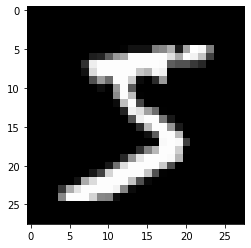

In [92]:
plt.imshow(img, cmap='gray') # to reverse cmap, append _r: 'gray_r'

In [93]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [94]:
y_train.shape

(60000,)

In [95]:
# We transform y to one-hot
# in order to avoid the network to think it's some kind of regression
# We could do it with a for loop
# but there's a utility for that

In [96]:
from tensorflow.keras.utils import to_categorical

In [97]:
y_cat_test = to_categorical(y_test,10)
y_cat_train = to_categorical(y_train,10)

In [98]:
y_cat_train.shape

(60000, 10)

In [99]:
y_cat_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [100]:
# We need to normalize the pixel values: [0,255] -> [0,1]
img.max()

255

In [101]:
x_test = x_test / x_test.max()
x_train = x_train / x_train.max()

In [102]:
x_test[0].max()

1.0

In [103]:
x_train[0].max()

1.0

In [104]:
# We need to reshape x to have a field for channels
# eventhough we have a single channel in our example

In [105]:
x_train.shape

(60000, 28, 28)

In [106]:
x_train = x_train.reshape((60000, 28, 28, 1))

In [109]:
x_train.shape

(60000, 28, 28, 1)

In [110]:
x_test = x_test.reshape((10000, 28, 28, 1))

In [111]:
x_test.shape

(10000, 28, 28, 1)

#### Create model

In [112]:
from tensorflow.keras.models import Sequential
# We load all layer types we're going to use
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [113]:
# We create the model with the layers
model = Sequential()

# CONVOLUTIONAL layer:
# 32 filters is quite standard (if complex images, more)
# 4x4 size for the filter kernels is also standard (3-4)
# input shape (for each image) is given by the dataset image shape
model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=(28,28,1), activation='relu'))

# POOLING layer:
# 2x2 is also quiste a standard size for max-pooling
# Note: in the new version of keras it's called MaxPooling2D - but MaxPool2D also works
model.add(MaxPool2D(pool_size=(2,2)))

# FLATTEN layer: 2D (images) --> 1D (for later class array)
model.add(Flatten())

# Map the flattened array to the class array with a fully connected layer
# The mapping is done in 2 steps (that's also quite usual)
# 28x28 = 784
# 28 - (3) = 25 -> 25x25 = 625; 4x4 kernel without padding and stride=1 results in 25 pixels
# floor(25/2)*floor(25/2) = 12x12 = 144; max-pool: every 4 pixels 1 (max) taken
# 144 -> 128 -> 10 (classes)
# Often powers of 2 are used as steps: 64, 128, 256, 512, 1024, ...
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax')) # last activation to classes requires softmax for probabilities

model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [116]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 591,786
Trainable params: 591,786
Non-trainable params: 0
_________________________________________________________________


#### Train model

In [125]:
# We can define early stopping:
# any time the accuracy starts becoming worse for the validation (test) split,
# we wait patience epochs without improvement and the training stops
from tensorflow.keras.callbacks import EarlyStopping

In [124]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [120]:
# Train: with or without early stopping
#model.fit(x_train, y_cat_train, epochs=2)
model.fit(x_train,y_cat_train,epochs=10,validation_data=(x_test,y_cat_test),callbacks=[early_stop])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.0399 - val_accuracy: 0.9874
Epoch 2/10
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.0277 - accuracy: 0.9916 - val_loss: 0.0461 - val_accuracy: 0.9869
Epoch 3/10
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.0433 - val_accuracy: 0.9882


#### Evaluate model

In [132]:
import pandas as pd

In [134]:
# Get metrics used to evaluate: loss, accuracy
model.metrics_names

['loss', 'accuracy']

In [136]:
# We can also create a dataframe with all the losses
losses = pd.DataFrame(model.history.history)

In [138]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,0.036317,0.989283,0.039946,0.9874
1,0.027709,0.991617,0.046125,0.9869
2,0.021871,0.993367,0.043286,0.9882


<AxesSubplot:>

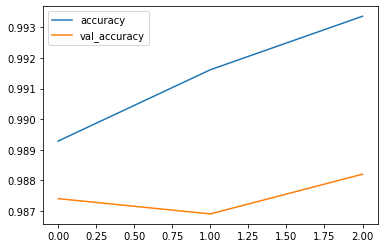

In [141]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

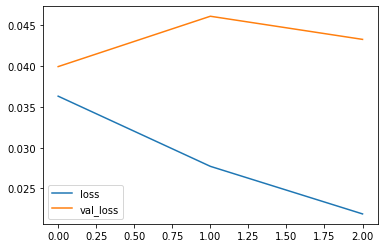

In [142]:
losses[['loss','val_loss']].plot()

In [143]:
# Test set should be similar to train set in terms of accuracy
# If train set is much better, we have overfitted
# loss, accuracy
model.evaluate(x_test, y_cat_test,verbose=0)

[0.0432859699132583, 0.9882]

In [144]:
from sklearn.metrics import classification_report,confusion_matrix

In [145]:
# IMPORTANT NOTE:
# model.predict_classes() does not deliver predictions as one-hot
# but as class categories 0-9
# HOWEVER, note that we train with categorical y values!
# This difference is relevant for the classification report
y_pred = model.predict_classes(x_test)

In [146]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [148]:
# We get very good results
# This type of standard conv networks (withthe architecture we defined)
# seems to work very well for hand-written digits
print(classification_report(y_test, y_pred)) # labels, predictions

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [151]:
confusion_matrix(y_test,y_pred)

array([[ 976,    0,    0,    1,    0,    0,    2,    0,    1,    0],
       [   1, 1124,    3,    1,    0,    1,    2,    2,    1,    0],
       [   1,    1, 1014,    4,    1,    0,    2,    6,    3,    0],
       [   0,    0,    1, 1006,    0,    1,    0,    0,    2,    0],
       [   0,    0,    0,    0,  973,    0,    5,    0,    1,    3],
       [   1,    0,    0,    7,    0,  882,    2,    0,    0,    0],
       [   4,    1,    0,    0,    1,    5,  946,    0,    1,    0],
       [   0,    0,    6,    0,    0,    0,    0, 1020,    1,    1],
       [   4,    1,    3,    1,    0,    0,    1,    5,  956,    3],
       [   0,    1,    0,    6,    7,    3,    0,    6,    1,  985]])

In [153]:
import seaborn as sns

<AxesSubplot:>

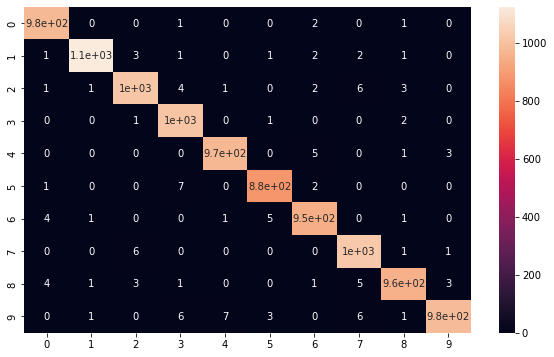

In [155]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
# https://github.com/matplotlib/matplotlib/issues/14751

### Example 2: CIFAR-10 Dataset

#### Load and prepare dataset

In [157]:
from tensorflow.keras.datasets import cifar10

In [158]:
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
# 32x32 images, 3 channels
# train: 50k images
# test: 10k images
x_train.shape

(50000, 32, 32, 3)

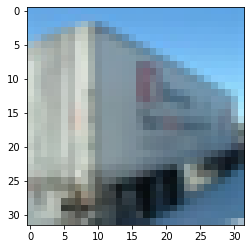

In [161]:
plt.imshow(x_train[15])

In [162]:
x_test.shape

(10000, 32, 32, 3)

In [163]:
x_test[0].max()

255

In [164]:
# Normalize
x_test = x_test / x_test.max()
x_train = x_train / x_train.max()

In [165]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [166]:
y_train.shape

(50000, 1)

In [167]:
# Transform to one-hot encoding
from tensorflow.keras.utils import to_categorical

In [168]:
y_cat_test = to_categorical(y_test,10)
y_cat_train = to_categorical(y_train,10)

In [169]:
y_cat_train.shape

(50000, 10)

In [170]:
# We can get the category names from Wikipedia:
# https://en.wikipedia.org/wiki/CIFAR-10

In [171]:
category_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [172]:
len(category_names)

10

#### Define model and train

In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [174]:
# We create the model with the layers
model = Sequential()

# CONVOLUTIONAL layer 1
model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=(32,32,3), activation='relu'))
# POOLING layer:
model.add(MaxPool2D(pool_size=(2,2)))

# CONVOLUTIONAL layer 2: since images are more complex, we add another conv-maxpool pair
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu'))
# POOLING layer:
# Note: in the new version of keras it's called MaxPooling2D - but MaxPool2D also works
model.add(MaxPool2D(pool_size=(2,2)))

# FLATTEN layer: 2D (images) --> 1D (for later class array)
model.add(Flatten())

# Map the flattened array to the class array with a fully connected layer
# Often powers of 2 are used; 512 gives a slightly better performance
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax')) # last activation to classes requires softmax for probabilities

model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [176]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 29, 29, 32)        1568      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 32)        16416     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               205056    
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [177]:
# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [178]:
# Train: with or without early stopping
#model.fit(x_train, y_cat_train, epochs=2)
model.fit(x_train,y_cat_train,epochs=15,validation_data=(x_test,y_cat_test),callbacks=[early_stop])

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 115s 2ms/sample - loss: 1.4946 - accuracy: 0.4654 - val_loss: 1.3898 - val_accuracy: 0.5143
Epoch 2/15
50000/50000 [==============================] - 117s 2ms/sample - loss: 1.1573 - accuracy: 0.5959 - val_loss: 1.2686 - val_accuracy: 0.5599
Epoch 3/15
50000/50000 [==============================] - 111s 2ms/sample - loss: 1.0114 - accuracy: 0.6488 - val_loss: 1.0270 - val_accuracy: 0.6497
Epoch 4/15
50000/50000 [==============================] - 112s 2ms/sample - loss: 0.9079 - accuracy: 0.6871 - val_loss: 1.0256 - val_accuracy: 0.6507
Epoch 5/15
50000/50000 [==============================] - 112s 2ms/sample - loss: 0.8308 - accuracy: 0.7149 - val_loss: 0.9749 - val_accuracy: 0.6680
Epoch 6/15
50000/50000 [==============================] - 115s 2ms/sample - loss: 0.7683 - accuracy: 0.7383 - val_loss: 1.1498 - val_accuracy: 0.6484
Epoch 7/15
50000/50000 [==========================

#### Evaluate model

In [181]:
import pandas as pd

In [182]:
losses = pd.DataFrame(model.history.history)

In [184]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,1.494552,0.46542,1.389804,0.5143
1,1.157304,0.59590,1.268581,0.5599
2,1.011379,0.64880,1.027049,0.6497
3,0.907909,0.68706,1.025576,0.6507
4,0.830773,0.71494,0.974932,0.6680


<AxesSubplot:>

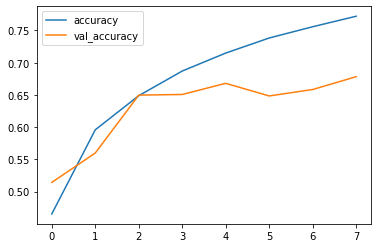

In [186]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

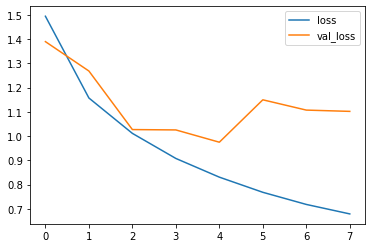

In [187]:
losses[['loss','val_loss']].plot()

In [179]:
# Evaluate
model.metrics_names

['loss', 'accuracy']

In [188]:
model.evaluate(x_test, y_cat_test, verbose=0)

[1.1021155710220336, 0.6783]

In [189]:
from sklearn.metrics import classification_report,confusion_matrix

In [190]:
y_pred = model.predict_classes(x_test)

In [191]:
print(classification_report(y_test, y_pred)) # labels, predictions

              precision    recall  f1-score   support

           0       0.68      0.76      0.72      1000
           1       0.79      0.82      0.81      1000
           2       0.60      0.55      0.58      1000
           3       0.41      0.65      0.50      1000
           4       0.69      0.63      0.66      1000
           5       0.61      0.52      0.56      1000
           6       0.79      0.74      0.77      1000
           7       0.79      0.68      0.73      1000
           8       0.76      0.81      0.78      1000
           9       0.86      0.62      0.72      1000

    accuracy                           0.68     10000
   macro avg       0.70      0.68      0.68     10000
weighted avg       0.70      0.68      0.68     10000



In [193]:
confusion_matrix(y_test,y_pred)

array([[758,  28,  36,  44,  18,   4,   5,  12,  77,  18],
       [ 36, 824,  15,  30,   3,   2,  13,   7,  31,  39],
       [ 75,   5, 554, 140,  69,  58,  56,  20,  17,   6],
       [ 25,   2,  65, 646,  47, 123,  41,  24,  19,   8],
       [ 24,   5,  69, 118, 632,  37,  50,  45,  20,   0],
       [ 12,   4,  58, 294,  38, 517,  17,  46,  12,   2],
       [  7,   7,  63, 111,  32,  21, 744,   3,  10,   2],
       [ 24,   4,  32, 106,  67,  65,   4, 682,   7,   9],
       [ 80,  41,   8,  33,   5,   8,   4,   1, 807,  13],
       [ 68, 123,  22,  63,   6,  14,   6,  22,  57, 619]])

<AxesSubplot:>

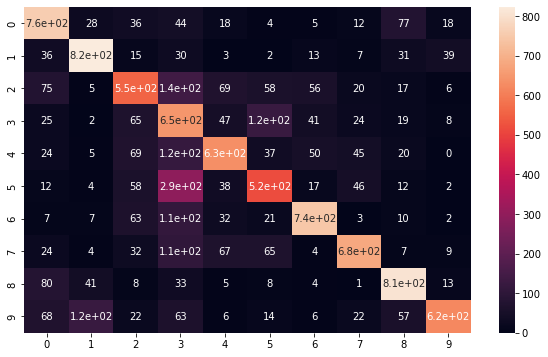

In [195]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
# https://github.com/matplotlib/matplotlib/issues/14751